In [1]:
from skimage.morphology import binary_dilation, binary_erosion

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import glob
from skimage.feature import canny
from matplotlib import patches

%matplotlib inline
np.random.seed(42)
plt.style.use('bmh')

In [3]:
# Plotting a bounding box on top of an image
# Create figure and axes
#fig,ax = plt.subplots(1, figsize=(14, 14))
#ax.imshow(sample_imgs[0])
#rect = patches.Rectangle((70, 70),2390,2185,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect)
#plt.axis('off');

## Preliminary Exploration

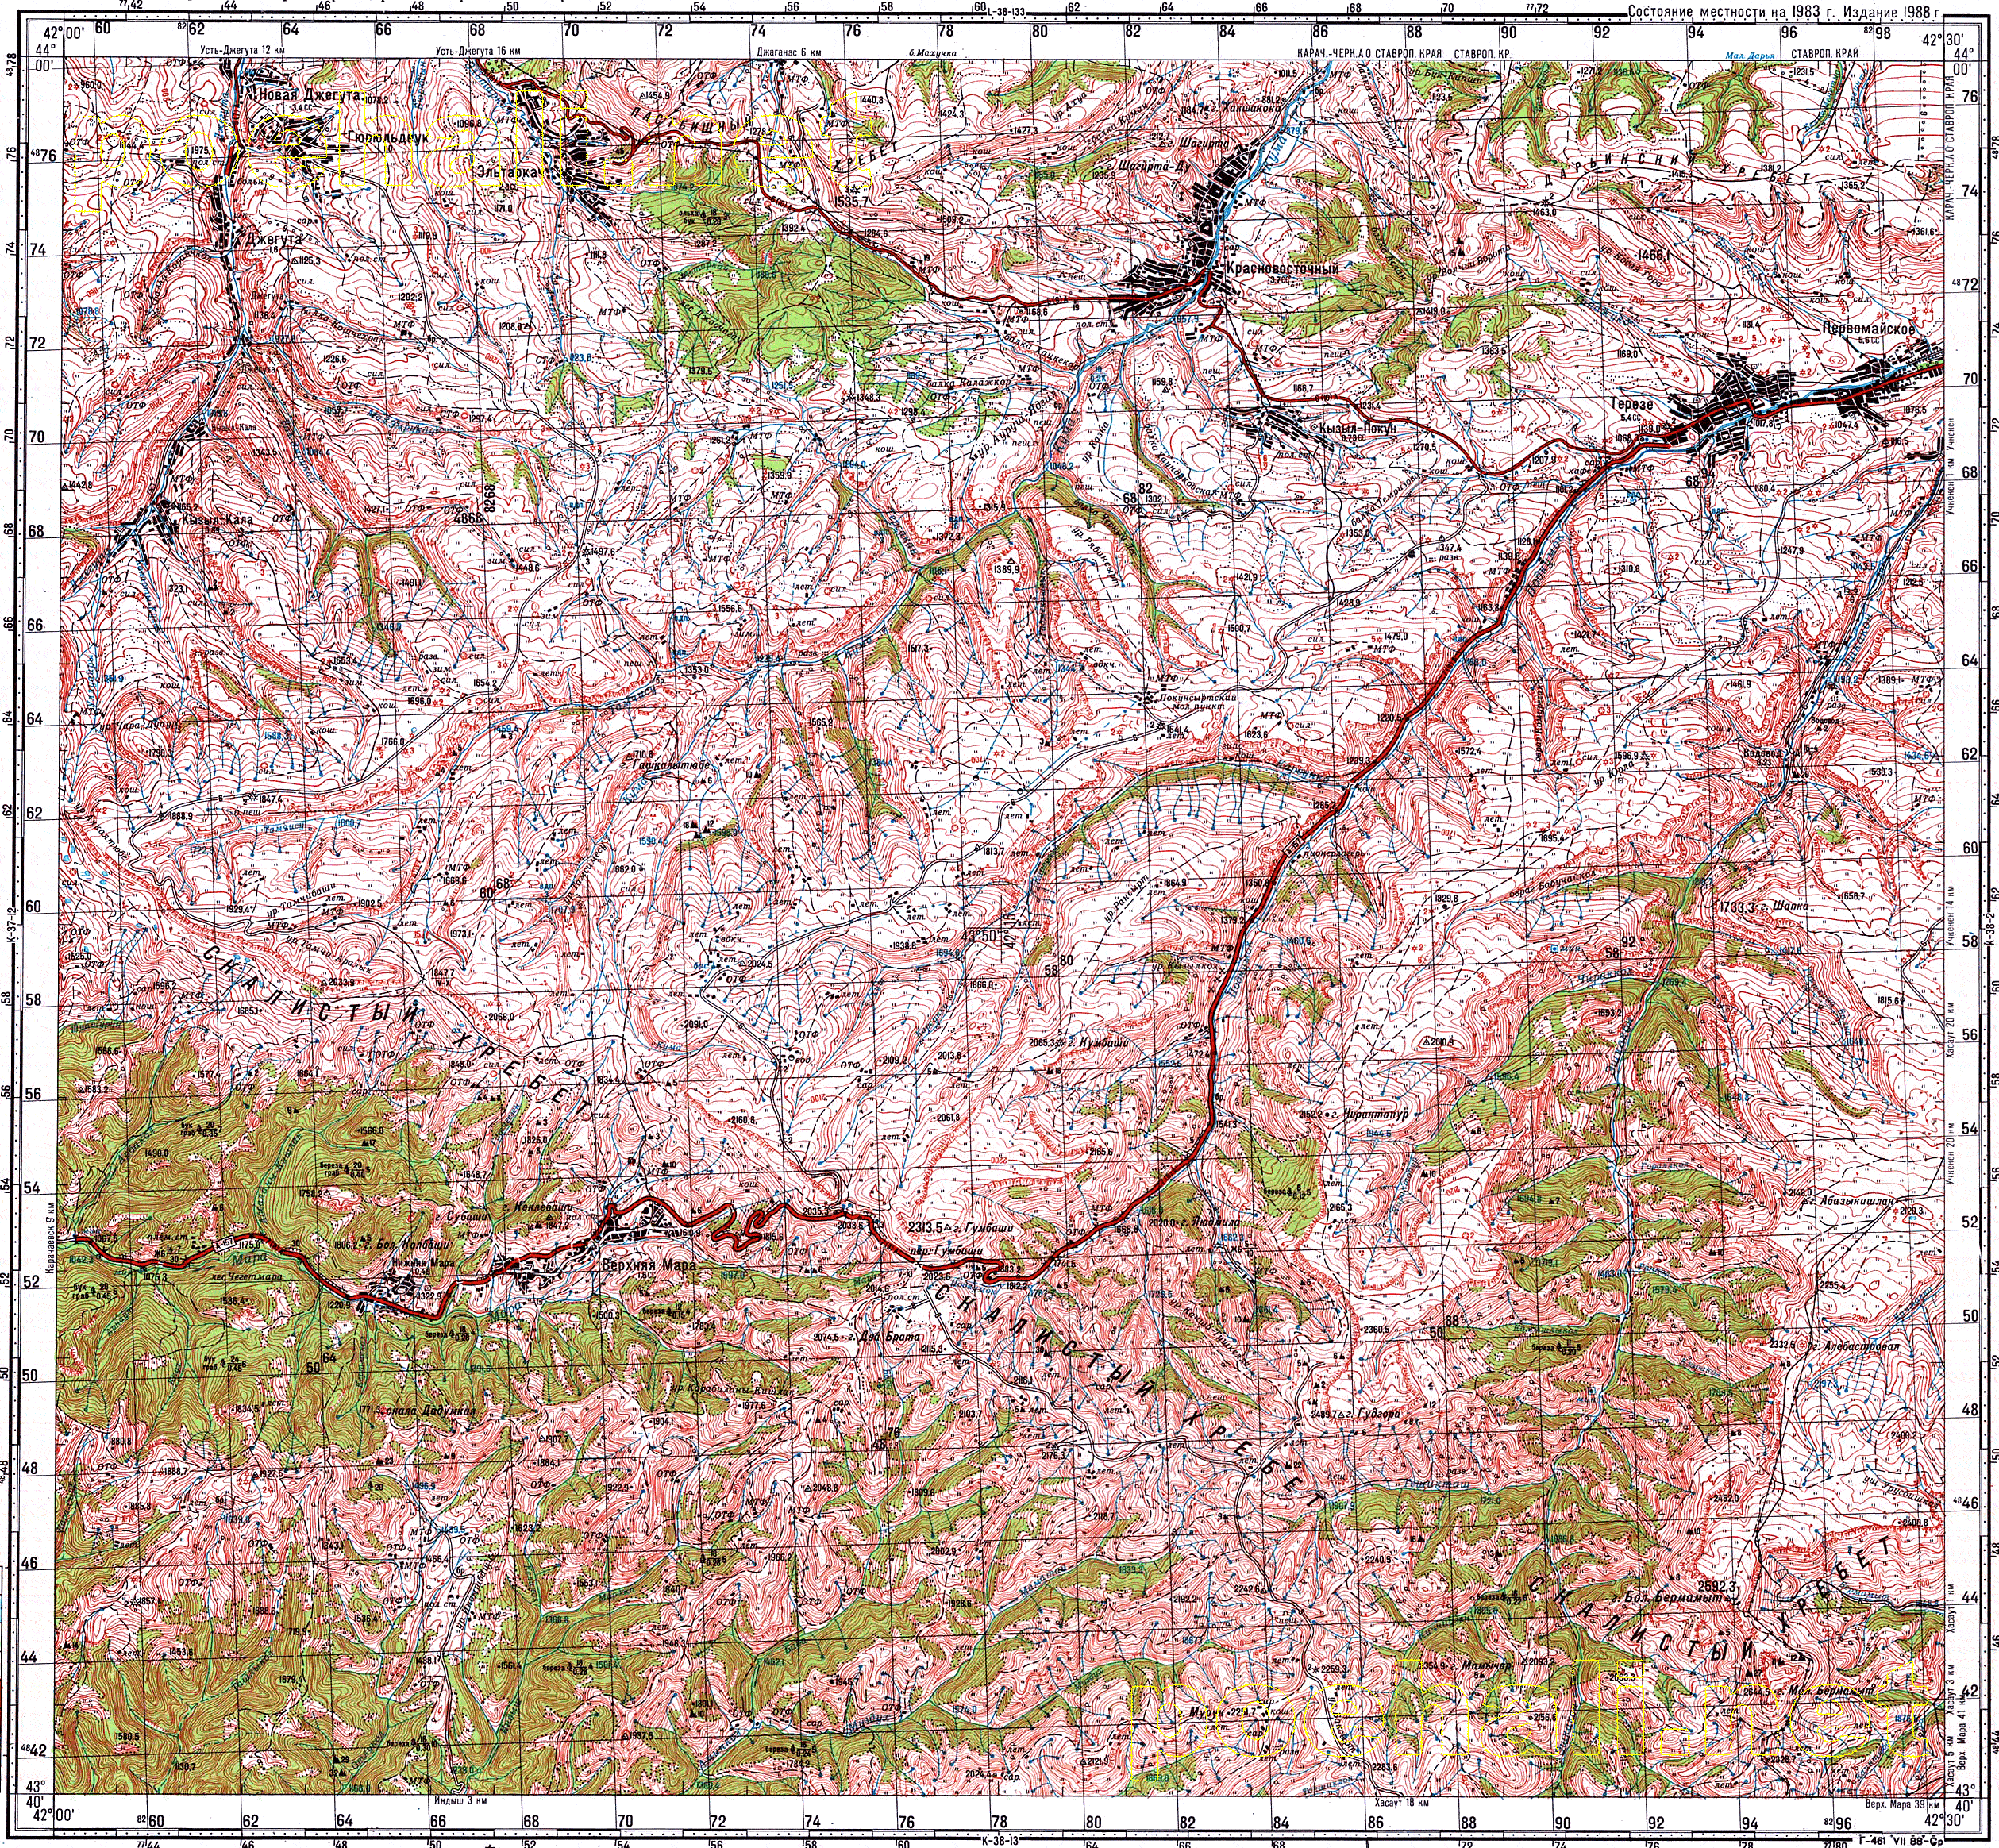

In [4]:
img_fps = glob.glob('./k38_lom_imgs/*.gif')
sample_img_fps = np.random.choice(img_fps, 5)
sample_imgs = [ndimage.imread(img_fp) for img_fp in sample_img_fps]

disp_img = Image.open('k38_lom_imgs/100k--k38-001.gif')
disp_img

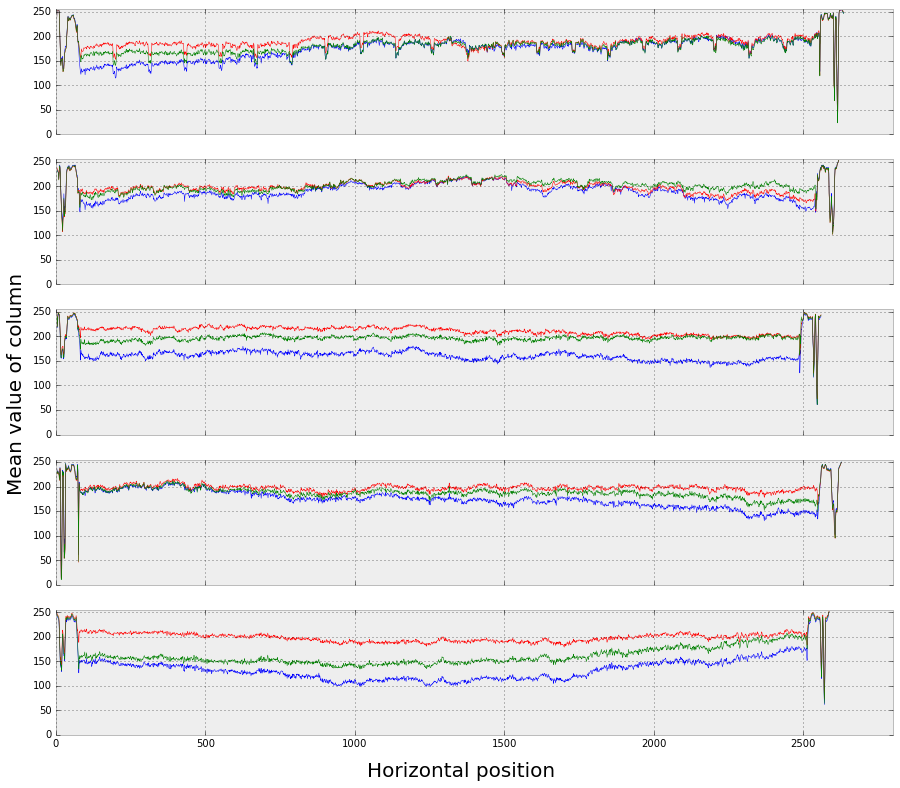

In [5]:
f, axs = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(15, 13))
for j, img in enumerate(sample_imgs):
    r, g, b = cv2.split(img)
    axs[j].plot(np.mean(b, axis=0), 'b', lw=0.5)
    axs[j].plot(np.mean(r, axis=0), 'r', lw=0.5)
    axs[j].plot(np.mean(g, axis=0), 'g' ,lw=0.5)
    axs[j].set_ylim(0, 255)
    axs[j].set_xlim(0, 2800)
f.text(0.5, 0.08, 'Horizontal position', ha='center', fontsize=20)
f.text(0.08, 0.5, 'Mean value of column', va='center', rotation='vertical', fontsize=20);

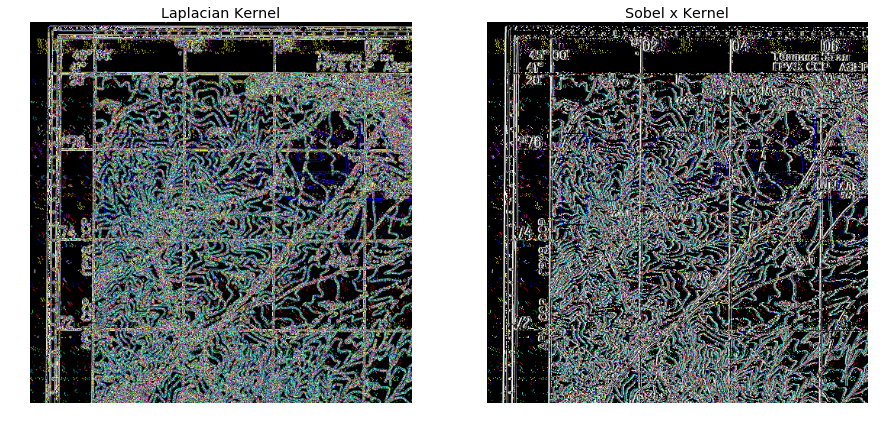

In [6]:
# Detecting the map's corners
f, axs = plt.subplots(1, 2, figsize=(15, 7))
img_x_grad_sobel = cv2.Sobel(sample_imgs[0], ddepth=cv2.CV_32F, dx=1, dy=0, ksize=1)
img_grad_lapl = cv2.Laplacian(sample_imgs[0], cv2.CV_32F, ksize=1)
axs[0].imshow(img_grad_lapl[:500, :500]); axs[0].set_title('Laplacian Kernel')
axs[1].imshow(img_x_grad_sobel[:500, :500]); axs[1].set_title('Sobel x Kernel')
axs[0].axis('off'); axs[1].axis('off');

In [29]:
img_gscale_sobel = ((cv2.cvtColor(img_x_grad_sobel, cv2.COLOR_RGB2GRAY)+255)/2).astype('uint8')

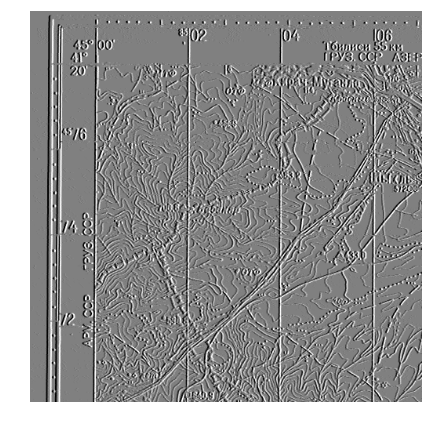

In [30]:
plt.figure(figsize=(7, 7))
plt.imshow(img_gscale_sobel[:500, :500], cmap='gray')
plt.axis('off');

## Solution

In [ ]:
# Algorithm
#---------------
# Find the first vertical/horizontal line
# Compute its direction vector
# Travel halfway along this line, then travel normal to its direction vector by 1/2 the big box size
# Translate the point reached to the center of the frame
# Rotate the image in the frame so that the vector is vertical
# Extract a fixed region of the image

def normal_filter(filter_width):
    return np.histogram(np.clip(np.random.randn(5000), -3, 3)+3, bins=filter_width)[0]

def get_vline(map_img, mode='position'):
    vertical_line_filter = np.ones([1, map_img.shape[0]])
    edges = canny(cv2.cvtColor(map_img, cv2.COLOR_RGB2GRAY)) # Flatten to depth = 1
    vline_scores = np.matmul(vertical_line_filter, edges) # Compute vline score
    if mode=='scores':
        return vline_scores.flatten()
    elif mode=='position':
        return np.where(vline_scores==max(vline_scores[0:50]))[0]

f, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)
for i in range(len(sample_imgs)):
    axs[i].plot(get_vline(sample_imgs[i], mode='scores'), color='k', lw=0.5)
    axs[i].yaxis.get_major_formatter().set_powerlimits((0, 5))
plt.xlim(0, 100)
plt.tight_layout()
plt.subplots_adjust(top=0.93, left=0.1)
plt.xlabel('Horizontal pixel position', fontsize=14)
f.text(0.03, 0.5, 'Vertical line score', va='center', rotation='vertical', fontsize=14);
plt.suptitle('Vertical line score against image x-position', fontsize=18);

In [212]:
def map_border_posn(map_img): # Returns points of map border corners, tl , tr, lr, ll
    gray = cv2.cvtColor(map_img, cv2.COLOR_RGB2GRAY)
    gray = cv2.bilateralFilter(gray, 10, 17, 17)
    thresh1 = cv2.Canny(gray, 30, 200)
    nz_px_posn = np.array(np.where(thresh1==255))
    img_width = sample_imgs[0].shape[1]
    img_height = sample_imgs[1].shape[0]
    img_corners = np.array([[0, 0, img_height, img_height], [0, img_width, img_width, 0]])
    posn = []
    for ix in range(4):
        corner = img_corners[:, ix, None]
        distances = np.linalg.norm(nz_px_posn-corner, axis=0)
        posn.append(nz_px_posn[:, np.where(distances==distances.min())])
    posn = np.array([pos.flatten() for pos in posn])
    return posn

In [217]:
def rect_center(quad): # Quad is defined as [tl, tr, lr, ll]
    tle, tri, lri, lle = quad
    diagonal = tri - lle
    center = np.round(ll + diagonal/2).astype(int)
    return center

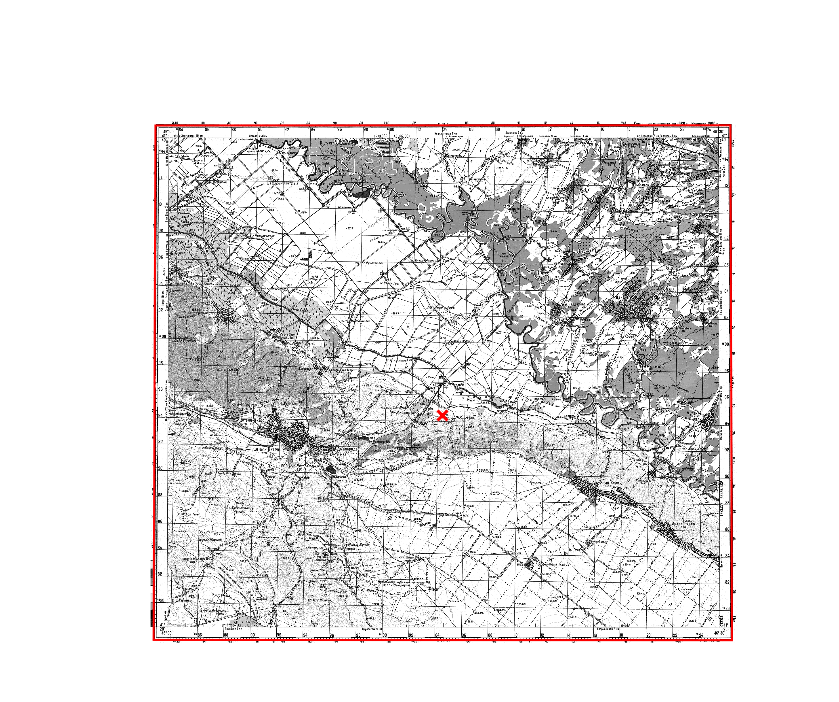

In [227]:
fig,ax = plt.subplots(1, figsize=(14, 14))
posn = map_border_posn(sample_imgs[1])
ax.imshow(sample_imgs[1][:,:,0], cmap='gray')
outer_rect = patches.Polygon(np.roll(posn, 1, axis=1), closed=True, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(outer_rect)
cnt = quad_center(posn)
plt.plot(cnt[1], cnt[1], 'rx', mew=3, markersize=10)
inner_posn = posn
plt.axis('off');

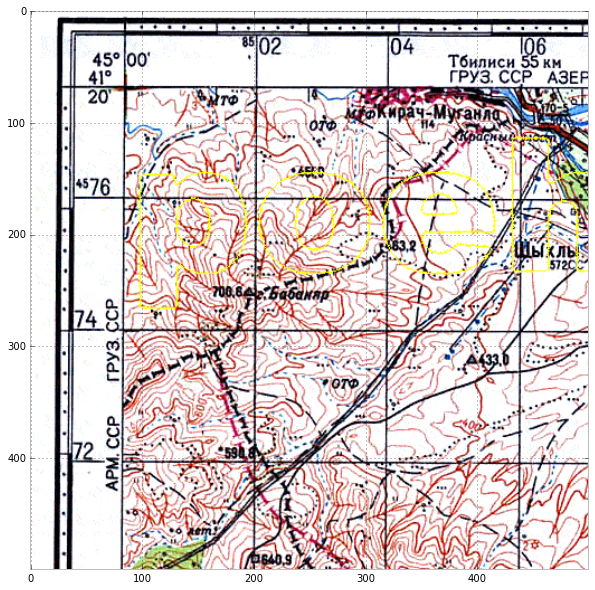

In [192]:
plt.figure(figsize=(10, 10))
plt.imshow(sample_imgs[0][:500, :500])